---
title: "Pairwise Alignment"
author: "Teo Sakel"
date: "10/01/2022"
execute:
  echo: false
format: 
  revealjs:
    fig-align: center
    fig-width: 6
    fig-height: 4
    fig-dpi: 300
    standalone: true
    embed-resources: true
    scrollable: true
highlight-style: pygments
---

In [1]:
# Basic Python
from itertools import chain, groupby
from bisect import bisect_left
from heapq import heappush, heappop
from math import comb
from scipy import optimize

# Numerical Staff
import numpy as np
from scipy import optimize

# Ploting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#%matplotlib inline

from Bio import SeqIO  # to read FASTA

# Custom functions that are not very informative to include in full
from utils.similarity import BLOSUM62, get_amino_freq
from utils.analysis import get_ladders_and_peaks, print_alignment
from utils.visualize import plot_path_graph, plot_alignment, plot_graph_alignment

In [2]:
plt.rc('figure', dpi=300)

# Why Sequence Similarity?

## Read Mapping

![](figures/read_mapping_1.png)

## Homology {.smaller}

:::: {.columns}

::: {.column width="50%"}

![Thomas Shafee, CC BY-SA 4.0, via Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Ortholog_paralog_analog_examples.svg/1024px-Ortholog_paralog_analog_examples.svg.png)

:::

::: {.column width="50%"}

![Rost, Burkhard. "Twilight zone of protein sequence alignments." Protein engineering (1999)](figures/twilight.png)

:::

::::

# What is Sequence Similarity?

## Distance Metrics

![](figures/distance_metrics.png)

## Edit Distance

1. **Hamming** distance: only <span style='color:#DF536B'> substitutions </span> 
2. Longest common sub-sequence (**LCS**): only <span style='color:#2297E6'> insertions/deletions </span>
3. **Levenshtein** distance: <span style='color:#DF536B'> substitutions </span> and <span style='color:#2297E6'> insertions/deletions </span>

![Adapted from SCHMID, R. (2006). Computational Genome Analysis](figures/edit_operations.png)

## Hamming Distance

In [3]:
#| echo: true

def hamming(S1, S2):
    assert len(S1) == len(S2)
    return sum(x != y for x, y in zip(S1, S2))

In [4]:
print(f'Distance of "this" vs "that" = {hamming("this", "that")}')

Distance of "this" vs "that" = 2


## Padded Hamming Distance

To extend the definition to strings of unequal length:

::: {.incremental}

- Define an extra "gap" character `-`
- Pad the shortest sequence with gaps until it matches the length of the longer.
- Count the number of differences between the *extended* sequences

:::

## Padded Hamming Distance

In [5]:
#| echo: true

def hamming(S0, S1):
    L = len(S0), len(S1)
    if L[0] == L[1]:
        return sum(x != y for x, y in zip(S0, S1))
    if L[0] < L[1]:
        # reverse so that S0 is longer (distance is symmetric)
        S0, S1 = S1, S0
        padding = '-' * (L[1] - L[0])
    else:
        padding = '-' * (L[0] - L[1])
    
    pref = hamming(S0, padding + S1)  # pad at the begining
    suff = hamming(S0, S1 + padding)  # pad at the end
    dist = min(pref, suff) # shortest path from S0 -> S1
    return dist  

In [6]:
print(f'Distance of "BANANA" vs "BANA" = {hamming("BANANA", "BANA")}')

Distance of "BANANA" vs "BANA" = 2




```
 pref  vs  suff
BANANA    BANANA
--BANA    BANA--
```

## Alignment


::: {.incremental}

- Given a sequence $S$, an *extended* sequence $S'$ is an arbitrary extension of $S$ with gap
  symbols `-`.
- A **global alignment** of $S$ and $Q$ is a 1-1 matching of their extended
  sequences $S'$ and $Q'$. The matching must be *co-linear* (no permutations of the 
  letters is allowed) and have no pairs of gaps aligned to each other.
- A **local alignment** is similar to a global one but not for the whole of $S'$ and $Q'$ 
  just contiguous segments.

:::

## Alignment Example

    
**Input**

```
S = HEAGAWGHEEAHGEGAE
Q = PAWHEAEHE
```

:::: {.columns}

::: {.column width="60%"}

**Global Alignment**

```
HEAGAWGHEEAHGEGAE
--P-AW-HE-A--EH-E
```

:::

::: {.column width="40%"}

**Local Alignment**

```
WGHEEAHGE
AW-HEAEHE
```
:::


::::

## Levenshtein = Hamming of Aligned Sequences {.smaller}

- <span style='color:#DF536B'> **Substitutions** </span> : if both sequences have a non-gap symbol there
- <span style='color:#2297E6'> **Insertions** </span>: if the $S'$ sequence has a gap. $Q$ has an extra symbols "inserted" at this position.
- <span style='color:#2297E6'> **Deletions** </span>: if the $Q'$ sequence has a gap. $Q$ has a symbol "deleted" at this position

In [7]:
#| echo: true

dHamm = hamming('MISSISSIPI', 'MISISSIPI')
dLeve = hamming('MISSISSIPI', 'MIS-ISSIPI')

In [8]:
print(f'Hamming = {dHamm} | Levensthein = {dLeve}')
print('------------|----------------')
print('MISSISSIPI  |   MISSISSIPI')
print('-MISISSIPI  |   MIS-ISSIPI')

Hamming = 3 | Levensthein = 1
------------|----------------
MISSISSIPI  |   MISSISSIPI
-MISISSIPI  |   MIS-ISSIPI


## Weighted Distance

:::: {.columns}

::: {.column width="50%"}

### Amino Acids 

![](figures/Amino_Acids_Venn_Diagram.png)

:::

::: {.column width="50%"}

### Nucleotides

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/All_transitions_and_transversions.svg/501px-All_transitions_and_transversions.svg.png)

:::

::::

## Substitution Matrices

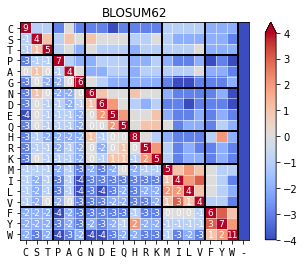

In [9]:
#| fig-height: 7
#| fig-width: 7

BLOSUM62.alphabet = 'CSTPAGNDEQHRKMILVFYW'
mat = BLOSUM62.to_array()
mat = np.hstack([mat, BLOSUM62.gap * np.ones((20, 1), dtype=int)])
plt.imshow(mat, norm=colors.CenteredNorm(halfrange=4), cmap='coolwarm')
plt.hlines(np.arange(20)+.5, -.5, 19.5, color='white', lw=.5)
plt.vlines(np.arange(21)+.5, -.5, 19.5, color='white', lw=.5)
plt.hlines(np.asarray([2, 5, 9, 12, 16]) + .5, -.5, 19.5, color='black', lw=2.)
plt.vlines(np.asarray([2, 5, 9, 12, 16, 19]) + .5, -.5, 19.5, color='black', lw=2.)
plt.xticks(np.arange(21), BLOSUM62.alphabet + '-', family='monospace')
plt.yticks(np.arange(20), BLOSUM62.alphabet, family='monospace')
plt.colorbar(extend='max')
for i in range(len(BLOSUM62.alphabet)):
    for j in range(len(BLOSUM62.alphabet)-i):
        plt.text(i, i+j, mat[i+j,i], size=9, ha='center', va='center', color='w')
plt.title('BLOSUM62')
plt.show()

## Weighted Hamming Distance

In [10]:
#| echo: true
#| code-line-numbers: "1,5,14"

def hamming(S0, S1, M):
    # score given by matrix M
    L = len(S0), len(S1)
    if L[0] == L[1]:
        return sum(M[x, y] for x, y in zip(S0, S1)) 
    if L[0] < L[1]:
        S0, S1 = S1, S0
        padding = '-' * (L[1] - L[0])
    else:
        padding = '-' * (L[0] - L[1])
    
    pref = hamming(S0, padding + S1, M) 
    suff = hamming(S0, S1 + padding, M)
    dist = max(pref, suff)  # max instead of min
    return dist

In [11]:
print(f'Distance of "PANAMA" vs "PAMA" based on BLOSUM62 = {hamming("PANAMA", "PAMA", BLOSUM62)}')

Distance of "PANAMA" vs "PAMA" based on BLOSUM62 = 5


# Dot Plot

## Definition 

A visual representation of *all possible local alignments*. 

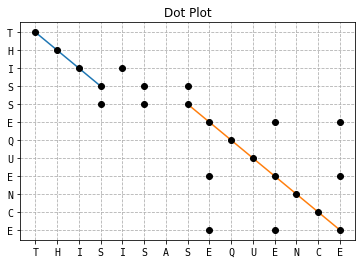

In [12]:
def dot_plot(S, Q=None):
    if Q is None:
        Q = S
    dots = [(i, j) for i, s in enumerate(S) for j, q in enumerate(Q) if s == q]
    return zip(*dots)  # return x & y seperately

S, Q = 'THISISASEQUENCE', 'THISSEQUENCE'  # from Understanding Bioinformatics
x, y = map(np.asarray, dot_plot(S, Q))
plt.plot(np.arange(4), len(Q) - np.arange(4))
plt.plot(np.arange(7, len(S)), 3+len(Q) - np.arange(7, len(S)))
plt.plot(x, len(Q)-y, 'o', color='black')  # reverse y to have top-down direction
plt.xticks(np.arange(len(S)), S, family='monospace')
plt.yticks(len(Q)-np.arange(len(Q)), Q, family='monospace')
plt.grid(ls = '--')
plt.title('Dot Plot')
plt.show()

## Patterns

- **Repeats**: `tomorrow and tomorrow and tomorrow`
- **Palidromes**: `can i see bees in a cave`

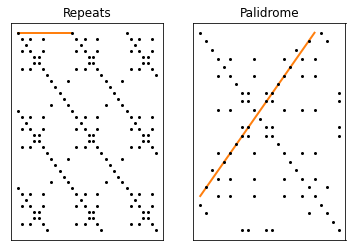

In [13]:
#| fig-height: 4
#| fig-width: 6

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(6, 4)

S = 'tomorrow and tomorrow and tomorrow'
#   '------14------
l = 13
x, y = map(np.asarray, dot_plot(S))
ax[0].plot([0, l], [len(S), len(S)], color='C1', lw=2.)
ax[0].plot(x, len(S)-y, 'o', color='black', markersize=2)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Repeats')

S = 'can i see bees in a cave'
#   '---------20----------
l = 20
x, y = map(np.asarray, dot_plot(S))
ax[1].plot(np.arange(l), np.arange(l) + len(S) - l + 1, color='C1', lw=2.)
ax[1].plot(x, len(S)-y, 'o', color='black', markersize=2)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Palidrome')

plt.show()

## Computation

In [14]:
#| echo: true

def dot_matrix(X, M, Y=None):
    if Y is None:
        Y = X
    dot = np.zeros((len(X), len(Y)), dtype=int)
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            dot[i, j] = M[x, y]
    return dot

## Example: [P00738](https://www.uniprot.org/uniprotkb/P00738/entry)

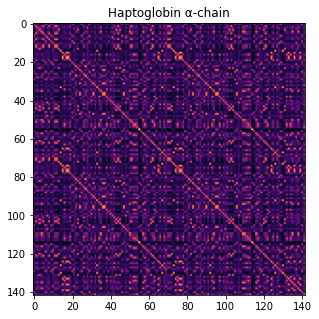

In [15]:
#| fig-height: 5
#| fig-width: 5

# Example from: https://doi.org/10.1111/j.1432-1033.1970.tb01046.x
# >sp|P00738|19-160
HP_alpha_chain = 'VDSGNDVTDIADDGCPKPPEIAHGYVEHSVRYQCKNYYKLRTEGDGVYTLNDKKQWINKAVGDKLPECEADDGCPKPPEIAHGYVEHSVRYQCKNYYKLRTEGDGVYTLNNEKQWINKAVGDKLPECEAVCGKPKNPANPVQ'
dot = dot_matrix(HP_alpha_chain, M=BLOSUM62)
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.imshow(dot, cmap='inferno')
ax.set_title('Haptoglobin α-chain')
plt.show()

## Denoising Alignments

1. Filtering (**T**hreshold)
2. Redundancy (**k**-mers)

## Filtering

Trade-off variance (noise) for bias (away from 0)

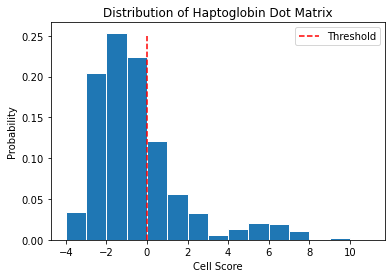

In [16]:
plt.hist(dot.flatten(), 15, density=True, facecolor='C0', edgecolor='white')
plt.vlines(0, 0, 0.25, color='red', linestyle='--', label='Threshold')
plt.xlabel('Cell Score')
plt.ylabel('Probability')
plt.title('Distribution of Haptoglobin Dot Matrix')
plt.legend()
plt.show()

## Redundancy {.scrollable}

> $k$-mers are substrings of length $k$ contained in a sequence

- are more robust to noise (mutations)
- carry more information ($\sum_{a=1}^k -\log_2 p_a$)
- can "vectorize" the text (dimension: $|\Sigma|^k$)


In [17]:
#| echo: true

def iter_words(text, k):
    L = len(text) - k + 1
    for i in range(L):
        yield text[i:i+k]

In [18]:
text = 'MISSISSIPPI'
k = 3
for i, word in enumerate(iter_words(text, k)):
    print(' '*i + word)
print(text)

MIS
 ISS
  SSI
   SIS
    ISS
     SSI
      SIP
       IPP
        PPI
MISSISSIPPI


## Denoised Dot Matrix

In [19]:
#| echo: true
#| code-line-numbers: "5,6,8"

def dot_matrix(X, M, Y=None, k=1, T=0):
    if Y is None:
        Y = X
    dot = np.zeros((len(X), len(Y)), dtype=int)
    for i, x in enumerate(iter_words(X, k)):
        for j, y in enumerate(iter_words(Y, k)):
            dot[i, j] = M(x, y)
    dot[dot < T] = 0
    return dot

## Denoised Dot Matrix

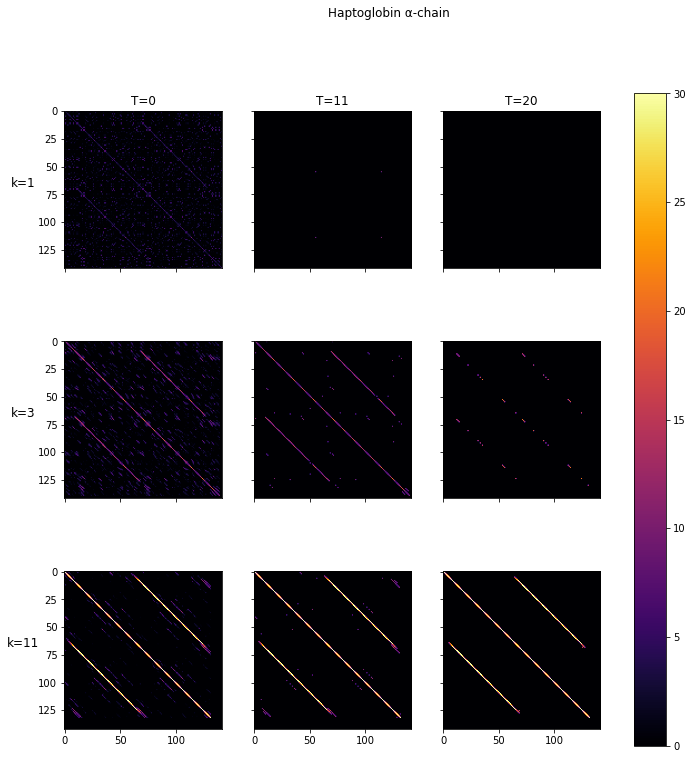

In [20]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))
for i, k in enumerate((1, 3, 11)):
    for j, T in enumerate((0, 11, 20)):
        dot = dot_matrix(HP_alpha_chain, M=BLOSUM62, k=k, T=T)
        dot = ax[i, j].imshow(dot, cmap='inferno', vmin=0, vmax=30)
        if j == 0:
            ax[i, j].set_ylabel(f'k={k}', rotation=0, labelpad=15, fontsize=12)
            #ax[i, j].yaxis.set_label_position('right')
        if i == 0:
            ax[i, j].set_title(f'T={T}')
fig.suptitle('Haptoglobin α-chain')
fig.colorbar(dot, ax=ax)
plt.show()

# Ungapped Alignment - BLAST

## Seed and Extend Strategy

With some extras...

0. **Index**: `dict` of $k$-mers positions
1. **Seed**: starting points
2. **Extend**: ungapped alignment 
3. **Xdrop**: early stopping heuristic
4. **E-value**: probability model for alignments
5. **Filtering**: use threshold to remove noise

## BLAST90

![Adapted form Harris, R.S., (2007) "Improved pairwise alignment of genomic DNA"](figures/blast90.png)

## BLAST90 Implementation 

In [21]:
#| echo: true
#| code-overflow: scroll
#| code-line-numbers:"20-29,45-59"

class BLAST90:
    def __init__(self, reference, score, k=3, T=13):
        self.score = score  # score matrix
        self.k = k  # length of word
        self.T = T  # Threshold
        self.store_reference(reference)
        self.scaling_const = self.score.calc_K_lambda(self.ref)
        self.index = self.build_index(self.ref)
    
    def store_reference(self, reference):
        self.proteins = list(reference.keys())
        self._prot_ranges = []
        self.ref = ''
        sep = self.score.gap_char * self.k  # protein separator
        for prot, seq in reference.items():
            self.ref += seq + sep
            self._prot_ranges.append((len(self.ref), prot))

    def build_index(self, reference):
        hits = {}
        # get positions of words
        for i, word in enumerate(self.iter_words(reference)):
            if self.score(word, word) < self.T:
                # non-informative word, self-similarity == max(score)
                continue
            try:
                hits[word].append(i)
            except KeyError:
                hits[word] = [i]
        
        # merge hits of 2 words if they are similar
        index = hits.copy()
        words = list(index.keys())
        for i, w1 in enumerate(words[:-1]):
            for w2 in words[i+1:]:
                if self.score(w1, w2) >= self.T:
                    index[w1] = self.merge_sorted(index[w1], hits[w2])
                    index[w2] = self.merge_sorted(index[w2], hits[w1])
        return index
    
    def get_protein(self, pos):
        ix = bisect_left(self._prot_ranges, (pos, ))
        return self._prot_ranges[ix][1]
    
    def search(self, query, Xdrop, Eval_cutoff):
        hits = []
        scanned = self.diagRanges()  # to avoid double checking a hit
        for i, word in enumerate(self.iter_words(query)):
            for j in self.index.get(word, []):
                seed = (i, j)
                if seed in scanned: 
                    continue
                Eval, offset = self.extend_seed(seed, query, Xdrop)
                scanned.append(seed, offset)
                if Eval < Eval_cutoff:
                    prot = self.get_protein(j)
                    # heappush keeps `hits` "sorted"
                    heappush(hits, (Eval, seed, offset, prot))
        return [heappop(hits) for i in range(len(hits))]
    
    def extend_seed(self, seed, pattern, Xdrop):
        k = self.k
        i, j = seed  # i: query, j: subject
        # extend forward
        query   = self.iter_seq(pattern , i, 1)
        subject = self.iter_seq(self.ref, j, 1)
        score_f, off_f = self.extend_ungapped(query, subject, Xdrop)
        # extend in reverse
        query   = self.iter_seq(pattern , i+k, -1)
        subject = self.iter_seq(self.ref, j+k, -1)
        score_r, off_r = self.extend_ungapped(query, subject, Xdrop)
        # final score = fwd + rev - word (word was added twice)
        score = score_f + score_r - self.score(pattern[i:i+k], self.ref[j:j+k])
        l     =   off_f +   off_r - k  # length of extension
        m = len(pattern) 
        Eval = self.compute_Eval(score, m, l)
        return Eval, (k - off_r, off_f)

    def extend_ungapped(self, pattern, ref, Xdrop):
        score = 0  # running score
        max_score, imax = 0, 0
        for i, (p, r) in enumerate(zip(pattern, ref)):
            score += self.score[p, r]
            if score >= max_score:
                # '==' is included because new max is longer
                max_score, imax = score, i
            elif max_score - score > Xdrop:
                break
        return max_score, imax + 1
    
    def compute_Eval(self, score, m, l):
        K, lam = self.scaling_const
        S = (lam * score - np.log(K)) / np.log(2)
        n = len(self.ref) - l + 1
        m = m - l + 1
        E = m * n * 2**(-S)
        return E
        
    def iter_words(self, text):
        N = len(text)
        k = self.k
        for i in range(N-k+1):
            yield text[i:i+k]
    
    def iter_seq(self, text, offset=0, step=1):
        if step > 0:
            text_range = range(offset, len(text), step)
        else:
            text_range = range(offset-1, -1, step)
        for i in text_range:
            yield text[i]
    
    def iter_seeds(self, query):
        for i, word in enumerate(self.iter_words(query)):
            for j in self.index.get(word, []):
                yield i, j
    
    @staticmethod
    def merge_sorted(X, Y):
        Lx, Ly = len(X), len(Y)
        # check if there is something to merge
        if Lx == 0:
            return Y
        if Ly == 0:
            return X
        
        Z = [None] * (Lx + Ly)
        iz, ix, iy = 0, 0, 0
        while True:
            if X[ix] > Y[iy]:
                Z[iz] = Y[iy]
                iy += 1
            else:
                Z[iz] = X[ix]
                ix += 1
            iz += 1
            if ix == Lx: # X is exhausted
                Z[iz:] = Y[iy:]
                break
            elif iy == Ly: # Y is exhausted
                Z[iz:] = X[ix:]
                break
        return Z
    
    # inside BLAST
    class diagRanges:
        def __init__(self):
            self.ranges = {}
        
        def append(self, coord, offset):
            row, col = coord
            diag = col - row
            interval = range(row+offset[0], row+offset[1])
            try:
                self.ranges[diag].append(interval)
            except KeyError:
                self.ranges[diag] = [interval]
        
        def __contains__(self, coord):
            row, col = coord
            diag = diag = col - row
            for interval in self.ranges.get(diag, []):
                if row in interval or col in interval:
                    return True
            return False

## Example

- [Draculin](https://en.wikipedia.org/wiki/Draculin)
- [NCBI BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi)

## BLAST Analysis - Xdrop

Motivation:

1. **Efficiency**: less time spend per seed
2. **Resolution**: avoid linking "independent" alignments


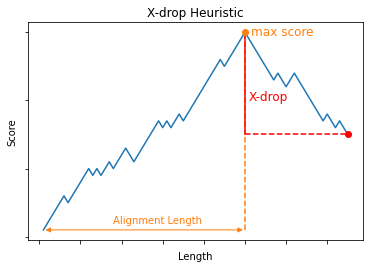

In [22]:
#| label: Xdrop
#| fig-height: 6
#| fig-width: 6


scores = np.asarray(50*[1] + 25*[-1])  # 50 matches and 25 misses
mutations = np.array([ 6, 12, 14, 17, 21, 22, 29, 31, 34, 44, 57, 60, 61, 69, 72])  # rng.uniform(size=75) > .75
scores[mutations] *= -1
scores = np.cumsum(scores)

plt.plot(1+np.arange(len(scores)), scores)
plt.plot(75, scores[74], 'ro')
plt.plot([50, 75], [scores[74], scores[74]], 'r--')
plt.plot([50, 50], [1, scores[49]], '--', color='C1')
plt.plot([50, 50], [scores[49], scores[74]], 'r-')
plt.plot(50, scores[49], 'o', color='C1')
plt.annotate('X-drop', (51, 20), color='red', fontsize='large')
plt.annotate('max score', (51.5, scores[49]-.5), color='C1', fontsize='large')
plt.annotate('', xy=(1, 1), xytext=(50, 1), arrowprops={'arrowstyle': '<|-|>', 'color': 'C1'})
plt.annotate('Alignment Length', xy=(18, 2), color='C1')
plt.title('X-drop Heuristic')
plt.xlabel('Length')
plt.ylabel('Score')
plt.xticks(ticks=np.arange(0, 80, 10), labels=[])
plt.yticks(ticks=np.arange(0, 40, 10), labels=[])
plt.show()

## Random Ungapped Alignments

### E-value metric: 

How many random local alignments of score $S$ or higher do we expect to recover for a query of length $m$?

### Model Parameters

Alignment are computed in 2 main steps:

1. Seeding
2. Extension


In [23]:
def random_sequencer(m, alphabet, p=None):
    if p is not None:
        p = np.array(p)
        assert np.all(p >= 0)
        p = p / sum(p)
    rng = np.random.default_rng()
    while True:
        yield ''.join(rng.choice(alphabet, m, replace=True, p=p))

amino_freq = get_amino_freq()  # dictionary {A: freq_A, ...}
aminos, amino_p = zip(*amino_freq.items())

## Seeding

Bigger matrices result in more seeds:

$$E \sim mn$$


In [24]:
N = 1000  # size of matrix
sequence_generator = iter(random_sequencer(N, aminos, amino_p))
ref = {'random': next(sequence_generator)}
q = next(sequence_generator)

blast = BLAST90(ref, BLOSUM62)

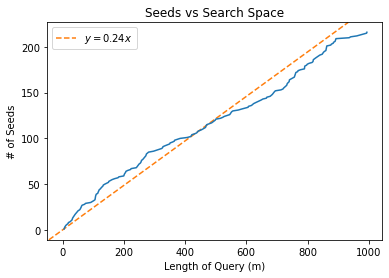

In [25]:
seeds = sorted(s for s in blast.iter_seeds(q))
seeds = np.array([(m, len(list(g))) for m, g in groupby(seeds, lambda x: x[0])])
x, y = seeds[:,0], np.cumsum(seeds[:, 1])
x += blast.k  # each position needs k residues to match
m = np.median(y/x)
plt.axline(xy1=(0, 0), slope=m, ls='--', color='C1', label=f'$y = {m:.2f}x$')
plt.plot(x, y)
plt.xlabel('Length of Query (m)')
plt.ylabel('# of Seeds')
plt.title('Seeds vs Search Space')
plt.legend()
plt.show()

## Alignment Score

The score of a random ungapped alignment equivalent to a negatively biased random walk.


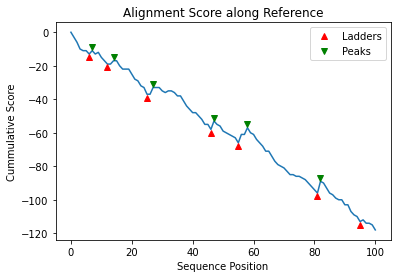

In [26]:
N = 100
sequence_generator = iter(random_sequencer(N, aminos, amino_p))

ref = next(sequence_generator)
q = next(sequence_generator)
X = np.array(BLOSUM62.trace(ref, q))
ladders, peaks = get_ladders_and_peaks(X)

plt.plot(np.arange(len(X)), X, '-')
#for l, p in zip(ladders, peaks): plt.plot(np.arange(l, p+1), X[l:p+1], color='C1')
plt.plot(ladders, X[ladders]-2., "^", color='red', label='Ladders')
plt.plot(peaks, X[peaks]+2., "v", color='green', label='Peaks')
plt.xlabel('Sequence Position')
plt.ylabel('Cummulative Score')
plt.title('Alignment Score along Reference')
plt.legend()
plt.show()

## Alignment Score

The probability of observing a score drops exponentially:

$$E \sim e^{-\lambda s}$$

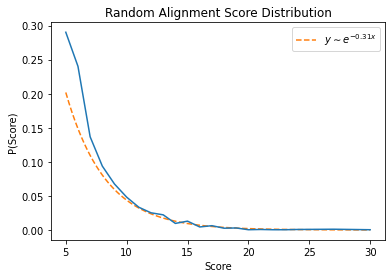

In [27]:
N = 1000
score_freq = {}
for _ in range(N):
    ref = next(sequence_generator)
    q = next(sequence_generator)
    X = np.array(BLOSUM62.trace(ref, q))
    ladders, peaks = get_ladders_and_peaks(X)
    scores = [X[p] - X[l] for l, p in zip(ladders, peaks)]
    for s in scores:
        score_freq[s] = score_freq.get(s, 0) + 1

scores, freqs = zip(*sorted(score_freq.items()))
scores, freqs = np.array(scores), np.array(freqs)
scores, freqs = scores[scores > 4], freqs[scores > 4]   # we primarily care for high scores
freqs = freqs/freqs.sum()
m, b = np.polyfit(scores, np.log(freqs), deg=1)

#m = np.median(np.log(freqs)/scores)
x = np.linspace(scores[0], scores[-1], 101)
y = np.exp(m*x + b)
plt.plot(x, y, '--', color='C1', label=f'$y \sim e^{{{m:.2f}x}}$')
plt.plot(scores, freqs)
plt.xlabel('Score')
plt.ylabel('P(Score)')
plt.title('Random Alignment Score Distribution')
plt.legend()
plt.show()

## Karlin-Altschul Theory

Building on these 2 intuition we can sketch a theory:

- The expected number of alignments: $E(S, m) = Kmne^{\lambda S}$
- Given just $E$ the distribution with the fewest added assumptions is the Poisson (1 parameter)
- The probability of observing one or more alignment with a given score is^[see assignment 1]:
  
$$P(N(S) \ge 1) = 1 - e^E$$


## BLAST Score

BLAST uses a normalized version of the score to calculate the E-value:

$$
\begin{align}
  S' &= \frac{\lambda S - \log K}{\log 2}\\
  E &= mn 2^{-S'}
\end{align}
$$

# Gapped Alignment (Levenstein Distance)

## The Problem

- [No right answer](https://training.galaxyproject.org/training-material/topics/sequence-analysis/tutorials/mapping/slides.html#12)
- [Hands-on experience](https://tinyurl.com/sequence-alignment)

## Dynamic Programming

From Wikipedia

> Dynamic programming is a method for solving a complex problem 
by breaking it down into a collection of simpler subproblems, 
solving each of those subproblems just once, and storing their solutions. 
The next time the same subproblem occurs, instead of recomputing its solution, 
one simply looks up the previously computed solution, 
thereby saving computation time at the expense of a (hopefully) modest expenditure in storage space.


## Alignment Problem Structure

We want to expand this approach now to address the optimal alignment problem.
So we have to

1. Recognize the “size” of the problem
2. Imagine how we could construct the optimal solution from smaller ones.
3. Apply the same scheme to the smaller problems until we reach a tractable problem.
4. Store the solutions of the simpler problems and use them to solve more complex one in order.

## Size of the problem

A natural metric of size is the length of the (finally) aligned sequences (bigger than either)

$$
\begin{aligned}
    \hat{X} &= \hat{x}_1\hat{x}_2 \dots \hat{x}_k & \hat{x} &\in \{x_1,\dots,x_m, \_\}\\
    \hat{Y} &= \hat{y}_1\hat{y}_2 \dots \hat{y}_k & \hat{y} &\in \{y_1,\dots,y_n, \_\} \\
\end{aligned}
$$

## Inductive Step

Focus on the last elements $(\hat{x}_k, \hat{y}_k)$. There are 3 possibilities:

$$
\begin{aligned}
    \hat{x}_k &= x_m & \hat{y}_k &= y_n \\
    \hat{x}_k &= x_m & \hat{y}_k &= \_ \\
    \hat{x}_k &= \_  & \hat{y}_k &= y_n 
\end{aligned}
$$

Each case correspond to a new **smaller** pair$:

$$
\begin{aligned}
    X' &= x_1 \dots x_{m-1} & Y' &= y_1 \dots y_{n-1} \\
    X' &= x_1 \dots x_{m-1} & Y \\
    X  &                 & Y' &= y_1 \dots y_{n-1} 
\end{aligned}
$$

## Inductive Hypothesis

Let $S_{X'Y'}, S_{X'Y}, S_{XY'}$ be the solutions to the smaller problems then:

$$ 
S_{X,Y} = \max
\begin{cases} 
    S_{X'Y'} &+& G(x_m, y_n) \\ 
    S_{X'Y} &+& G(x_m, \_) \\ 
    S_{XY'} &+& G(\_,y_n) 
\end{cases} 
$$

## Base Case

The optimal alignment of a string $X$ with an empty string '' is:

$$
\begin{aligned}
    x_1 x_2 &\dots x_n \\
    \mathtt{\_\_} &\dots \mathtt{\_\_}
\end{aligned}
$$

## Path Graph

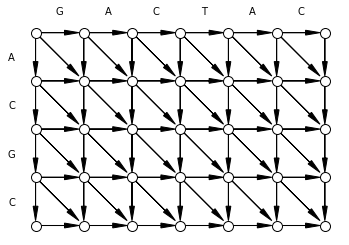

In [28]:
S1, S2 = 'ACGC', 'GACTAC'
fig, ax = plt.subplots()
plot_path_graph(ax, S1, S2)
plt.show()

## Cost of Edges

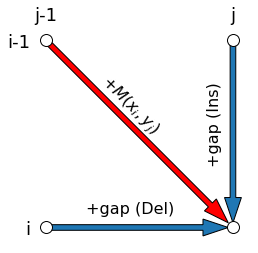

In [29]:
fig, ax = plt.subplots()
ax.plot([0, 0, 1, 1], [0, 1, 0, 1], 'o', markerfacecolor='white', markeredgecolor='black', markersize=12)

arrow_pad = .025
ax.arrow(0, 1, 1-arrow_pad, arrow_pad-1, width = .03, length_includes_head=True, facecolor='red')
ax.arrow(0, 0, 1-arrow_pad, 0, width = .03, length_includes_head=True)
ax.arrow(1, 1, 0, arrow_pad-1, width = .03, length_includes_head=True)

ax.text(.45, .1, '+gap (Del)', ha='center', va='center', fontsize=16)
ax.text(.9, .55, '+gap (Ins)', ha='center', va='center', fontsize=16, rotation=90)
ax.text(.45, .65, '$+M(x_i,y_j)$', ha='center', va='center', fontsize=16, rotation=-45)


#ax.text(1.1, 0, '$S_{ij}$', ha='center', va='center', fontsize=16)
ax.set_xticks(ticks=[0, 1], labels=['j-1', 'j'], fontsize=18)
ax.set_yticks(ticks=[0, 1], labels=['i', 'i-1'], fontsize=18)    
ax.axes.set_aspect('equal')
ax.tick_params(length=0, labelbottom=False, labeltop=True)
ax.set_frame_on(False)
plt.show()

## Induction {.scrollable}

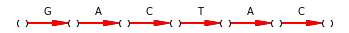

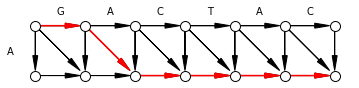

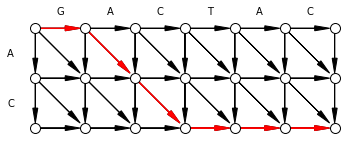

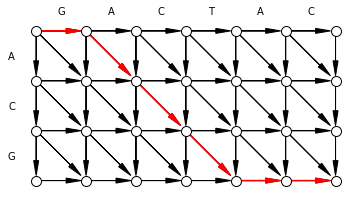

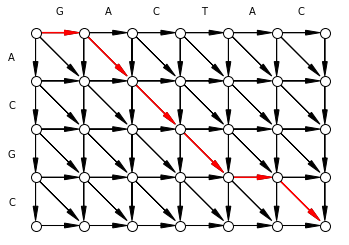

In [30]:
S1, S2 = 'ACGC', 'GACTAC'
CIGAR = 'DMMMDM'  # optimal alignment
Midx =  [0,2,3,4,6]  # length of CIGAR consumed by each prefix of S1

for m in range(len(S1)+1): 
    M = Midx[m]
    cigar = CIGAR[:M] + 'D' * (len(S2)-M)
    #input(f'Align "{S1[:m]}" with "{S2}"')
    fig, ax = plt.subplots()
    plot_path_graph(ax, S1[:m], S2)
    plot_graph_alignment(ax, S1[:m], S2, cigar)
    plt.show()

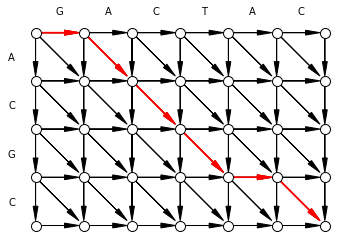

In [31]:
fig, ax = plt.subplots()
plot_path_graph(ax, S1, S2)
#plot_graph_alignment(ax, S1, S2, 'MDMIDDM')
plot_graph_alignment(ax, S1, S2, 'DMMMDM')
plot_graph_alignment(ax, S1, S2, 'DMMMDM')
# -ACG-C        -AC-GC
# GACTAC        GACTAC
plt.show()

## Needleman-Wunsch Algorithm

Finds **global alignment**

In [32]:
#| echo: true

def NeedlemanWunsch(x, y, M):
    # Initialize Variables
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # cost matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    # Initialize 1st column/row
    for i in range(1, m):
        S[i, 0] = S[i-1, 0] + M(x[i-1], '_')
    P[1:, 0] = 2
    
    for j in range(1, n):
        S[0, j] = S[0, j-1] + M('_', y[j-1])
    P[0, 1:] = 3
    
    # Main Recursion
    for i in range(1, m):
        for j in range(1, n):
            scores = (S[i-1, j-1] + M(x[i-1], y[j-1]), # match
                      S[i-1,  j ] + M(x[i-1],   '_' ), # insertion
                      S[ i , j-1] + M(  '_' , y[j-1])) # deletion
            
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax + 1
            
    return S, P

## Global Alignment Example

In [33]:
#| echo: true

def SimpleCost(x, y):
    if x != y:
        return -1
    return 0

X, Y = "THISLINE", "ISALIGNED"
S, P = NeedlemanWunsch(X, Y, SimpleCost)

#--ISALIGNED
#THIS-LI-NE-

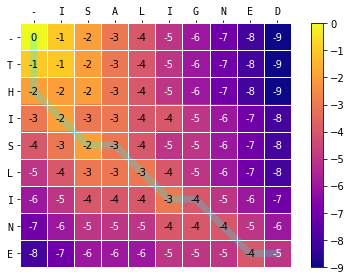

In [34]:
fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P)
fig.tight_layout()
plt.show()

## Semi-global Algorithm

::: {.smaller}

Ignores gap at the beginning and end of alignment ~ `grep`

:::

In [35]:
#| echo: true
#| code-line-numbers: "8-16"

def NeedlemanWunsch(x, y, M, algorithm="global"):
    # Initialize Variables
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # cost matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    # Initialize 1st column/row
    if algorithm == 'global':
        for i in range(1, m):
            S[i, 0] = S[i-1, 0] + M(x[i-1], '_')
        P[1:, 0] = 2
        for j in range(1, n):
            S[0, j] = S[0, j-1] + M('_', y[j-1])
        P[0, 1:] = 3
    elif algorithm == 'semi':
        pass
    else:
        raise ValueError(f'Unknown algorithm specified: {algorithm}')
    
    # Main Recursion
    for i in range(1, m):
        for j in range(1, n):
            scores = (S[i-1, j-1] + M(x[i-1], y[j-1]), # match
                      S[i-1,  j ] + M(x[i-1],   '_' ), # insertion
                      S[ i , j-1] + M(  '_' , y[j-1])) # deletion
            
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax + 1
            
    return S, P

## Example Global vs Semi-Global

:::: {.columns}

::: {.column width="50%"}

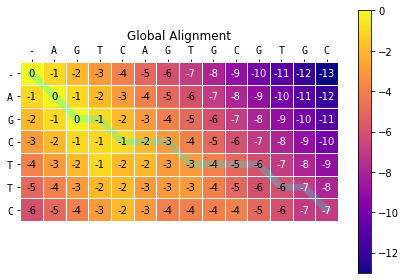

In [36]:
# TODO: compare semi to global
X, Y = 'AGCTTC', 'AGTCAGTGCGTGC'
NW_res = {'global': NeedlemanWunsch(X, Y, SimpleCost, algorithm="global"),
          'semi': NeedlemanWunsch(X, Y, SimpleCost, algorithm="semi")}

S, P = NW_res['global']

fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P)
ax.set_title('Global Alignment')
fig.tight_layout()
plt.show()

In [37]:
print_alignment(X, Y, P)

AGTCAGTGCGTGC
|| |  |   | |
AG-C--T---T-C


:::

::: {.column width="50%"}

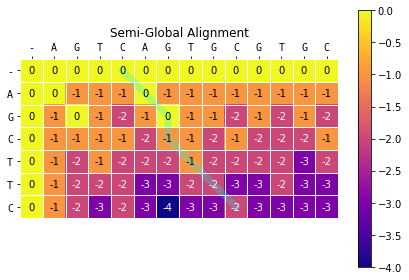

In [38]:
S, P = NW_res['semi']

fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, best=(6, 9))
ax.set_title('Semi-Global Alignment')
fig.tight_layout()
plt.show()

In [39]:
print_alignment(X, Y, P)

CG-TGC
 | | |
AGCTTC


:::

::::

## Local Alignment

<p style="text-align:center;"><img src="figures/alignment_types.svg" width="600" height="600"></p>

## Smith-Waterman Algorithm

1. Negative cell are set to 0
2. Backtracking should start at the highest value and stop at 0.


In [40]:
#| echo: true
#| code-line-numbers: "4,10"

def SmithWaterman(x, y, M):
    # Initialize Variables
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # cost matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    # Main Recursion
    for i in range(1, m):
        for j in range(1, n):
            scores = (0,                               # restart
                      S[i-1, j-1] + M(x[i-1], y[j-1]), # match
                      S[i-1,  j ] + M(x[i-1],   '_' ), # insertion
                      S[ i , j-1] + M(  '_' , y[j-1])) # deletion
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax
    
    return S, P

## Example Global vs Local

:::: {.columns}

::: {.column width="50%"}

In [41]:
def align(x, y, M, algorithm="global"):
    """ Calculate global alignment value of sequences x and y using
        dynamic programming.  Return global alignment value. """
    # Initialize Variables
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # cost matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    if algorithm == 'global':
        # Initialize 1st column/row
        for i in range(1, m):
            S[i, 0] = S[i-1, 0] + M[x[i-1], '-']
        P[1:, 0] = 2

        for j in range(1, n):
            S[0, j] = S[0, j-1] + M['-', y[j-1]]
        P[0, 1:] = 3
        lb = -2**32  # it will never be picked
    elif algorithm == 'semi':
        lb = -2**32  # it will never be picked
    elif algorithm == "local":
        lb = 0
    else:
        raise ValueError(f'Unknown algorithm specified: {algorithm}')
    
    # Main Recursion
    for i in range(1, m):
        for j in range(1, n):
            scores = (lb,                              # restart
                      S[i-1, j-1] + M[x[i-1], y[j-1]], # match
                      S[i-1,  j ] + M[x[i-1],   '-' ], # insertion
                      S[ i , j-1] + M[  '-' , y[j-1]]) # deletion
            
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax
            
    return S, P

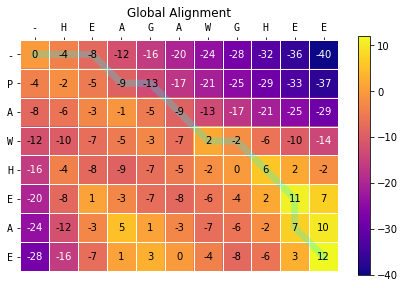

In [42]:
# from: Biological Sequence Analysis - Durbin et al
X, Y = 'PAWHEAE', 'HEAGAWGHEE'
res = {'global': align(X, Y, BLOSUM62, algorithm="global"),
       'local': align(X, Y, BLOSUM62, algorithm="local")}

S, P = res['global']

fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, pathcolor='cyan')
ax.set_title('Global Alignment')
fig.tight_layout()
plt.show()

In [43]:
print_alignment(X, Y, P)

HEAGAWGHE-E
    || || |
--P-AW-HEAE


:::

::: {.column width="50%"}

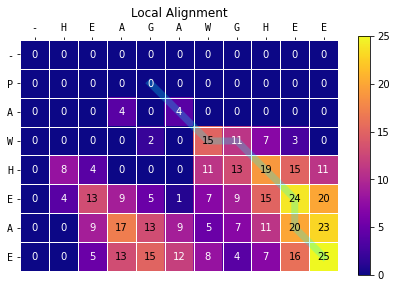

In [44]:
S, P = res['local']
best = S.argmax()

fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, best=best, pathcolor='cyan')
ax.set_title('Local Alignment')
fig.tight_layout()
plt.show()

In [45]:
print_alignment(X, Y, P)

AWGHE-E
|| || |
AW-HEAE


:::

::::

## Generalized Gap Score

$$ G(\text{gap}) = C_{\text{open}} + C (l_{\text{gap}}) $$

### Affine Gap

$$ G(\text{gap}) = C_{\text{open}} + C \cdot l_{\text{gap}}$$

## Concave vs Affine Gap Penalty

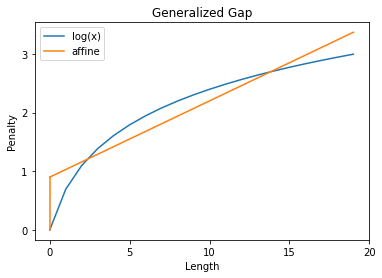

In [46]:
x = 1 + np.arange(20)
plt.plot(x-1, np.log(x), color='C0', label='log(x)')
plt.plot(x-1, 0.77 + .13*x, color='C1', label='affine')
plt.plot([0, 0], [0, .9], color='C1')
plt.ylabel('Penalty')
plt.xlabel('Length')
plt.title('Generalized Gap')
plt.xticks([0, 5, 10, 15, 20])
plt.yticks(np.arange(4))
plt.legend()
plt.show()

## SW with Affine Gap

In [47]:
#| echo: true
#| code-line-numbers: "10-17"

def SmithWaterman(x, y, M, gapOpen, gapExtend):
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # score matrix
    D = np.zeros((m, n), dtype=int)  # deletion matrix
    I = np.zeros((m, n), dtype=int)  # insertion matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    for i in range(1, m):
        for j in range(1, n):
            D[i, j] = max(S[i, j-1] - gapOpen,   # open a deletion gap
                          D[i, j-1] - gapExtend) # extend deletion gap
            I[i, j] = max(S[i-1, j] - gapOpen,   # open a insertion gap
                          D[i-1, j] - gapExtend) # extend insertion gap
            scores  = (0,
                       S[i-1, j-1] + M[x[i-1], y[j-1]],
                       I[i, j],
                       D[i, j])
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax
    return S, P

## Example Global vs Local

:::: {.columns}

::: {.column width="50%"}

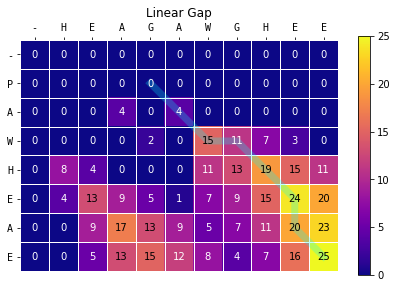

In [48]:
# from: Biological Sequence Analysis - Durbin et al
X, Y = 'PAWHEAE', 'HEAGAWGHEE'
res = {'linear': SmithWaterman(X, Y, BLOSUM62, gapOpen=4, gapExtend=4),  # open == extend
       'affine': SmithWaterman(X, Y, BLOSUM62, gapOpen=8, gapExtend=4)}

S, P = res['linear']
best = S.argmax()

fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, best=best, pathcolor='cyan')
ax.set_title('Linear Gap')
fig.tight_layout()
plt.show()

In [49]:
print_alignment(X, Y, P)

AWGHE-E
|| || |
AW-HEAE


:::

::: {.column width="50%"}

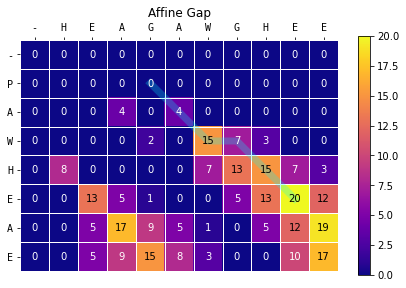

In [50]:
S, P = res['affine']
best = S.argmax()

fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, best=best, pathcolor='cyan')
ax.set_title('Affine Gap')
fig.tight_layout()
plt.show()

In [51]:
print_alignment(X, Y, P)

AWGHEE
||   |
AWHEAE


:::

::::

## PSI-BLAST

1. Smith-Waterman algorithm to extend
2. Seeds require 2 hits
3. Iterated search

![](figures/blast2.png)


## 2D Xdrop

1. Early Stopping
2. Limits the search to a [band of diagonals](https://ieeexplore.ieee.org/document/8445105)

![](figures/smith_waterman_heuristics.png)

## Extreme Value Statistic

- The Karlin-Altschul Theory no longer applies because we are **optimizing** not *summing*
the alignment score.
- We can swap the Poisson model with 
  [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution) 
  which is common for maximum values statistics


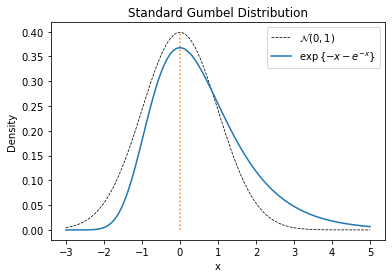

In [52]:
def dgumbel(x, scale=1., loc=0.):
    z = (x - loc) / scale  # z-score
    return np.exp(-z - np.exp(-z))/scale

def dnorm(x, scale=1., loc=0.):
    z = (x - loc) / scale  # z-score
    const = np.sqrt(2*np.pi) * scale  # normalizing constant
    return np.exp(-0.5 * z**2) / const

x = np.linspace(-3, 5, num=100)
plt.vlines(0., 0., dnorm(0.), color='C1', linestyles='dotted')
plt.plot(x, dnorm(x), '--k', label='$\mathcal{N}(0, 1)$', linewidth=.75)
plt.plot(x, dgumbel(x), label='$\exp\{-x-e^{-x}\}$', color='C0')
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Standard Gumbel Distribution')
plt.show()